## Timing our algorithms

In [7]:
import time, random
import pandas as pd
import seaborn as sns
import matplotlib as plt
import sys

In [16]:
from parsers.read_fasta import read_fasta_file
from parsers.read_fastq import read_fastq_file
from search_st import SuffixTree

In [17]:
def dna(length=int(), letters="CGTA"):
    return''.join(random.choices(letters, k=length))

def create_fasta(start, stop, step):
    name = f"test_files/n_{stop}.fasta"
    f = open(name, "w")
    counter = 1

    for i in range(start, stop, step):
        f.write('>Seq' + str(counter) + '\n' + dna(i) + '\n')
        counter += 1
    f.close()

    return name

def create_fastq(m):
    name = f"test_files/m_{m}.fastq"
    f = open(name, "w")
    f.write(
        '@' + 'Seq' + str(1) + '\n' + 
        dna(m) + '\n' + 
        '+' + '\n' + 
        '~' * m + '\n')
    f.close()
    
    return name

In [ ]:
def search_suffix(fasta,fastq):

    if len(fasta) < 0 or len(fastq) < 0:
        return "Problems with either fasta or fastq file"

    flag, mapq, pnext, tlen = 0,0,0,0
    rnext = "*"

    for x in fasta.items():
        rname = x[0]
        tree = None
        tree = SuffixTree()
        tree.root.children = [None, None, None, None, None]
        tree.insert(x[1])


        for p in fastq.items():
            qname = p[0]
            substring = p[1][0]
            cigar = str(len(substring)) + "M"
            qual = p[1][1]

            seq = [tree.alpha[a] for a in substring]
            
            matches = tree.search_rec(tree.root, 0, 0, seq)

            if matches is not None:
                for match in matches:
                    pos = int(match) + 1
                    print(f"{qname}\t{flag}\t{rname}\t{pos}\t{mapq}\t{cigar}\t{rnext}\t{pnext}\t{tlen}\t{substring}\t{qual}", file = sys.stdout)

In [13]:
def time_st(n, m):
    df = pd.DataFrame(range(20, n, int(n/10)), columns=['n'])
    fastq = create_fastq(m)
    fasta = create_fasta(20, n, int(n/10))

    fastq_dict = read_fastq_file(fastq)
    fasta_dict = read_fasta_file(fasta)
    times = []


    for item in fastq_dict.items():
        for seq in fasta_dict.items():
            start = time.time()
            search_suffix(seq, item)
            end = time.time()
            difference = end - start
            times.append(difference)
    
    df['Time'] = times

    df['Time/Expected time'] = df['Time']/df['n']*m
    return df


In [14]:
n = 1000000
df_10 = time_st(n, 10)

AttributeError: 'tuple' object has no attribute 'items'

In [20]:
n = 1000000
df_10 = time_st(n, 10)
df_10000 = time_st(n, 10000)
df_50000 = time_st(n, 50000)
df_100000 = time_st(n, 100000)
df_500000 = time_st(n, 500000)
df_900000 = time_st(n, 900000)

Seq1 0 Seq5 292496 0 10M * 0 0 TAATAGCACC ~~~~~~~~~~
Seq1 0 Seq6 125206 0 10M * 0 0 TAATAGCACC ~~~~~~~~~~
Seq1 0 Seq7 57952 0 10M * 0 0 TAATAGCACC ~~~~~~~~~~
Seq1 0 Seq7 570717 0 10M * 0 0 TAATAGCACC ~~~~~~~~~~
Seq1 0 Seq7 587586 0 10M * 0 0 TAATAGCACC ~~~~~~~~~~
Seq1 0 Seq9 275715 0 10M * 0 0 TAATAGCACC ~~~~~~~~~~


In [21]:
concat = pd.concat([
    df_10.assign(dataset='m = 10'),
    df_10000.assign(dataset='m = 10000'), 
    df_50000.assign(dataset='m = 50000'), 
    df_100000.assign(dataset='m = 100000'), 
    df_500000.assign(dataset='m = 500000'), 
    df_900000.assign(dataset='m = 900000')
    ], ignore_index = True)

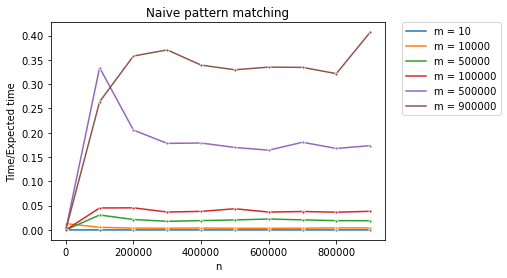

In [37]:
h = sns.lineplot(x = 'n', y = 'Time/Expected time', 
                    hue = 'dataset', marker = '.',
                    data = concat)
h.set_title('Naive pattern matching')
h.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
h.figure.savefig('figures/naive_search.pdf')